In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/airlines/Airline_Delay_Cause.csv


In [3]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve,mean_absolute_error, mean_squared_error, r2_score
import shap
import matplotlib.pyplot as plt

In [4]:
df = pd.read_csv('/kaggle/input/airlines/Airline_Delay_Cause.csv')

In [19]:
#CREATE DELAY FRACTION AND TARGET
df = df[df['arr_flights'] > 0]

# Calculate safely
df['delay_fraction'] = (df['arr_del15'] / df['arr_flights']).replace([np.inf, -np.inf], 0).fillna(0)
df['mean_arr_delay'] = (df['arr_delay'] / df['arr_flights']).replace([np.inf, -np.inf], 0).fillna(0)

# Define target
delay_threshold = 0.3
df['delayed'] = np.where(df['delay_fraction'] > delay_threshold, 1, 0)

# Check distribution
print("Target distribution:\n", df['delayed'].value_counts())


Target distribution:
 delayed
0    157503
1     21494
Name: count, dtype: int64


use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.


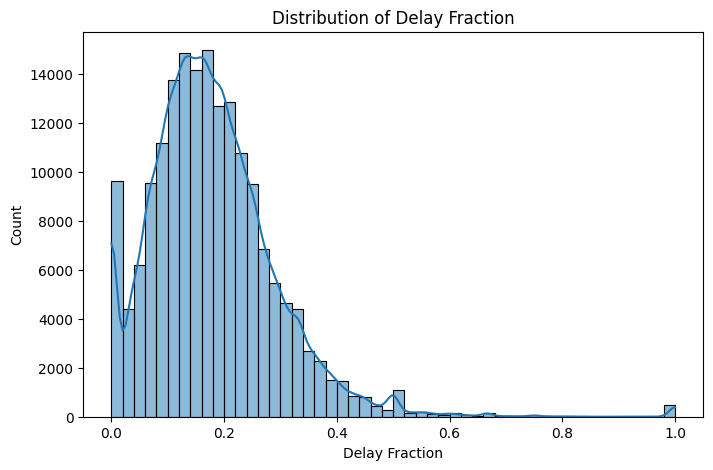

In [32]:
# EDA -DELAY FRACTION DISTRIBUTION
import seaborn as sns
df['delay_fraction'] = (df['arr_del15'] / df['arr_flights']).replace([np.inf, -np.inf], 0).fillna(0)
plt.figure(figsize=(8,5))
sns.histplot(df['delay_fraction'], bins=50, kde=True)
plt.title('Distribution of Delay Fraction')
plt.xlabel('Delay Fraction')
plt.ylabel('Count')
plt.savefig('Distribution of Delay Fraction.png', dpi=300, bbox_inches='tight')
plt.show()

In [33]:
import os
# List files saved in the working directory
print(os.listdir('/kaggle/working'))


['Distribution of Mean Arrival Delay(min).png', '.virtual_documents', 'Distribution of Delay Fraction.png']


use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.


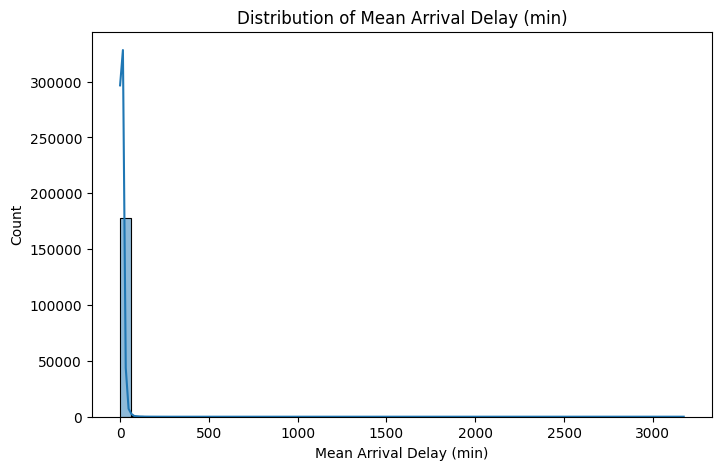

In [30]:
# EDA-MEAN DELAY DISTRIBUTION
plt.figure(figsize=(8,5))
sns.histplot(df['mean_arr_delay'], bins=50, kde=True)
plt.title('Distribution of Mean Arrival Delay (min)')
plt.savefig('Distribution of Mean Arrival Delay(min).png', dpi=300, bbox_inches='tight')
plt.xlabel('Mean Arrival Delay (min)')
plt.ylabel('Count')
plt.show()

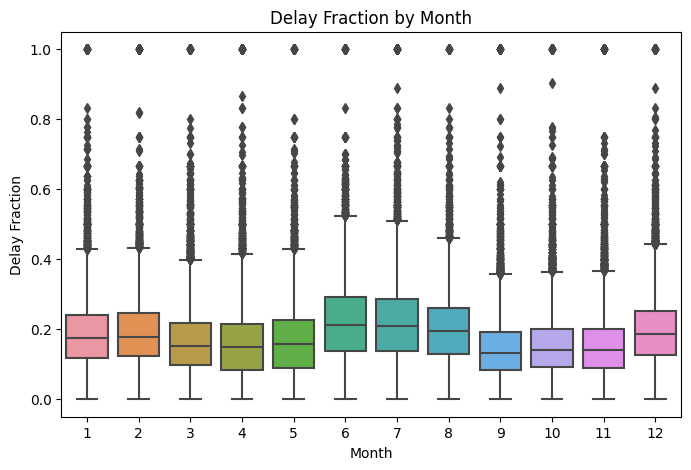

In [35]:
# EDA-TEMPORAL PATTERNS - MONTHLY
plt.figure(figsize=(8,5))
sns.boxplot(x='month', y='delay_fraction', data=df)
plt.title('Delay Fraction by Month')
plt.xlabel('Month')
plt.ylabel('Delay Fraction')
plt.savefig('Delay Fraction by Month.png', dpi=300, bbox_inches='tight')
plt.show()

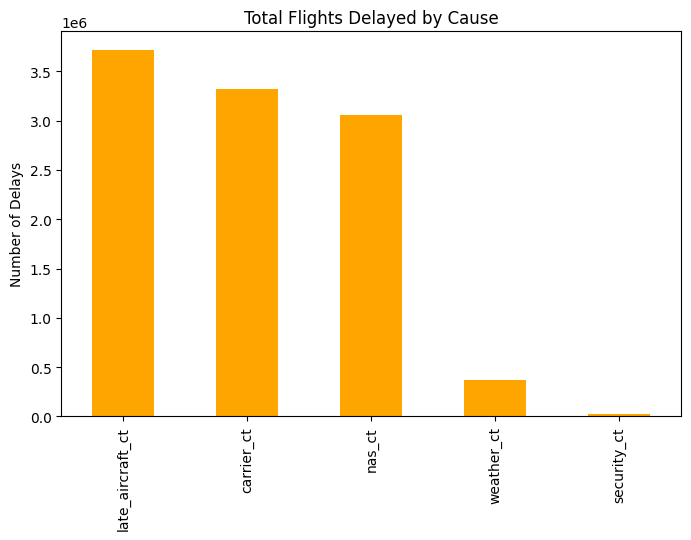

In [36]:
# EDA-DELAY CAUSES CONTRIBUTION
delay_causes = ['carrier_ct', 'weather_ct', 'nas_ct', 'security_ct', 'late_aircraft_ct']
delay_sums = df[delay_causes].sum().sort_values(ascending=False)

plt.figure(figsize=(8,5))
delay_sums.plot(kind='bar', color='orange')
plt.title('Total Flights Delayed by Cause')
plt.ylabel('Number of Delays')
plt.savefig('Total Flights Delayed by Cause.png', dpi=300, bbox_inches='tight')
plt.show()

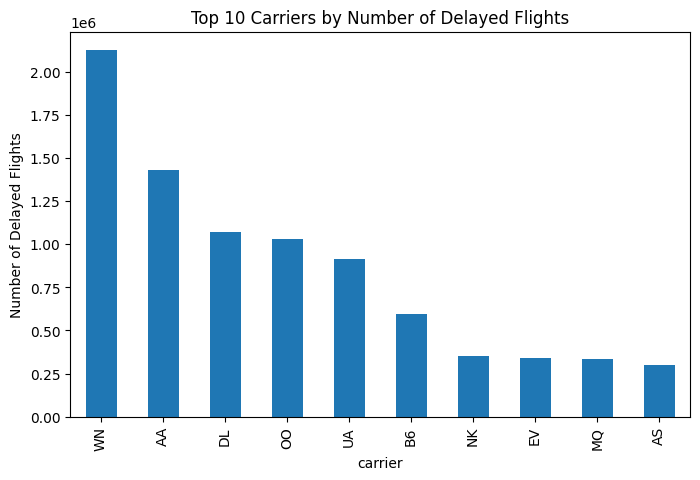

In [38]:
# EDA-TOP CARRIERS BY DELAY
top_carriers = df.groupby('carrier')['arr_del15'].sum().sort_values(ascending=False).head(10)
plt.figure(figsize=(8,5))
top_carriers.plot(kind='bar')
plt.title('Top 10 Carriers by Number of Delayed Flights')
plt.ylabel('Number of Delayed Flights')
plt.savefig('Top 10 Carriers by Number of Delayed Flights.png', dpi=300, bbox_inches='tight')
plt.show()

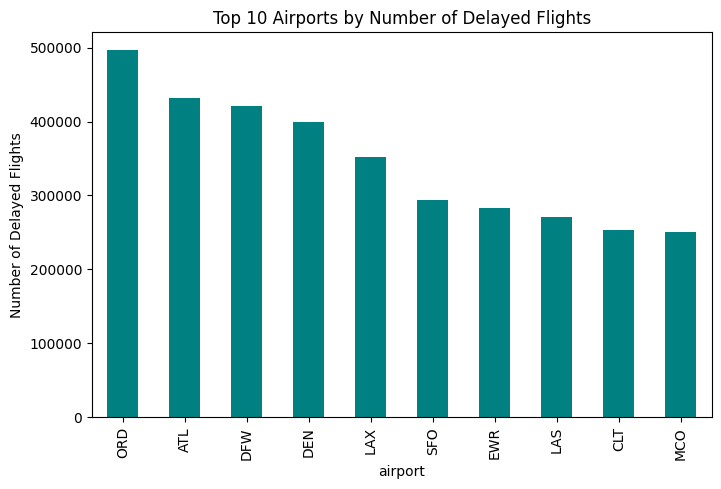

In [39]:
# EDA-TOP AIRPORTS BY DELAY
top_airports = df.groupby('airport')['arr_del15'].sum().sort_values(ascending=False).head(10)
plt.figure(figsize=(8,5))
top_airports.plot(kind='bar', color='teal')
plt.title('Top 10 Airports by Number of Delayed Flights')
plt.ylabel('Number of Delayed Flights')
plt.savefig('Top 10 Airports by Number of Delayed Flights.png', dpi=300, bbox_inches='tight')
plt.show()

In [27]:
# ROOT CAUSE SUMMARY
print("\nRoot Cause Breakdown (Total Delay Counts):")
print(delay_sums)

print("\nTop Carriers Contributing to Delays:")
print(top_carriers)

print("\nTop Airports Contributing to Delays:")
print(top_airports)


Root Cause Breakdown (Total Delay Counts):
late_aircraft_ct    3719285.11
carrier_ct          3324447.29
nas_ct              3059941.04
weather_ct           364391.74
security_ct           26009.57
dtype: float64

Top Carriers Contributing to Delays:
carrier
WN    2127071.0
AA    1432707.0
DL    1069460.0
OO    1032571.0
UA     917137.0
B6     595690.0
NK     350973.0
EV     340885.0
MQ     331745.0
AS     302122.0
Name: arr_del15, dtype: float64

Top Airports Contributing to Delays:
airport
ORD    496364.0
ATL    432555.0
DFW    420954.0
DEN    399147.0
LAX    352582.0
SFO    293470.0
EWR    283188.0
LAS    271292.0
CLT    252863.0
MCO    250893.0
Name: arr_del15, dtype: float64


In [9]:
# SELECT FEATURES
features = [
    'month', 'carrier', 'airport', 'arr_flights',
    'carrier_ct', 'weather_ct', 'nas_ct', 'security_ct', 'late_aircraft_ct',
    'arr_cancelled', 'arr_diverted',
    'carrier_delay', 'weather_delay', 'nas_delay', 'security_delay', 'late_aircraft_delay'
]

X = df[features]
# y = df['delayed']

X = pd.get_dummies(X, columns=['carrier', 'airport'], drop_first=True)
# Ensure all features are numeric (float64)
X = X.apply(pd.to_numeric, errors='coerce').fillna(0)
# Optionally check for remaining NaNs
# print("NaNs in X:", X.isna().sum().sum())

# Fill any NaNs (if necessary)
# X = X.fillna(0)
X_train, X_test, y_train_cls, y_test_cls = train_test_split(X, df['delayed'], stratify=df['delayed'], test_size=0.3, random_state=42)
y_train_reg = df.loc[y_train_cls.index, 'mean_arr_delay']
y_test_reg = df.loc[y_test_cls.index, 'mean_arr_delay']




In [10]:
# HANDLE IMBALANCE WITH CLASS WEIGHTS

pos = y_train_cls.sum()
neg = len(y_train_cls) - pos
scale_pos_weight = neg / pos
print(f"Classifier scale_pos_weight = {scale_pos_weight:.2f}")


Classifier scale_pos_weight = 7.33


In [11]:
# XGBOOST MODEL
clf = xgb.XGBClassifier(
    objective='binary:logistic',
    scale_pos_weight=scale_pos_weight,
    eval_metric='logloss',
    use_label_encoder=False,
    random_state=42
)
clf.fit(X_train, y_train_cls)

y_pred_cls = clf.predict(X_test)
y_prob_cls = clf.predict_proba(X_test)[:, 1]

print("\nCLASSIFICATION REPORT")
print(classification_report(y_test_cls, y_pred_cls))
print("ROC-AUC:", roc_auc_score(y_test_cls, y_prob_cls))


CLASSIFICATION REPORT
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     47252
           1       0.85      0.99      0.91      6448

    accuracy                           0.98     53700
   macro avg       0.92      0.98      0.95     53700
weighted avg       0.98      0.98      0.98     53700

ROC-AUC: 0.9984085776090142


In [12]:
# REGRESSOR (optionally only on groups classifier predicts as delayed)
reg = xgb.XGBRegressor(
    objective='reg:squarederror',
    eval_metric='rmse',
    random_state=42
)
reg.fit(X_train, y_train_reg)

y_pred_reg = reg.predict(X_test)

mae = mean_absolute_error(y_test_reg, y_pred_reg)
rmse = np.sqrt(mean_squared_error(y_test_reg, y_pred_reg))
r2 = r2_score(y_test_reg, y_pred_reg)

print(f"\nREGRESSION RESULTS")
print(f"MAE: {mae:.2f} min | RMSE: {rmse:.2f} min | R²: {r2:.3f}")


REGRESSION RESULTS
MAE: 0.84 min | RMSE: 3.28 min | R²: 0.943


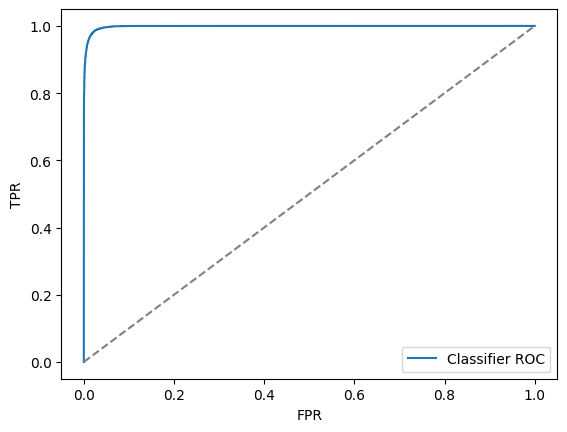

In [40]:
# ROC curve
fpr, tpr, _ = roc_curve(y_test_cls, y_prob_cls)
plt.plot(fpr, tpr, label='Classifier ROC')
plt.plot([0,1],[0,1],'--',color='gray')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()
plt.savefig('FPR vs TPR.png', dpi=300, bbox_inches='tight')
plt.show()


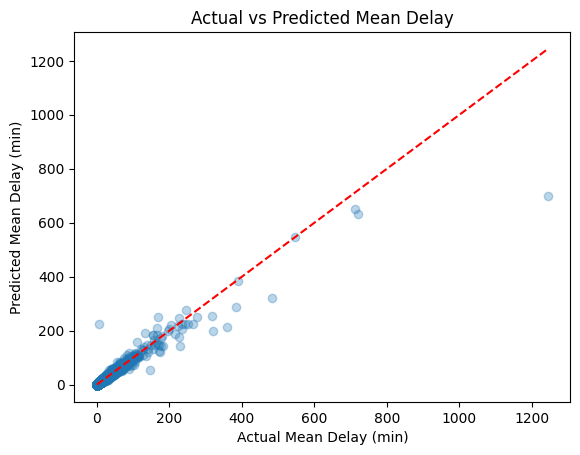

In [41]:
# True vs predicted delay
plt.scatter(y_test_reg, y_pred_reg, alpha=0.3)
plt.xlabel("Actual Mean Delay (min)")
plt.ylabel("Predicted Mean Delay (min)")
plt.plot([y_test_reg.min(), y_test_reg.max()], [y_test_reg.min(), y_test_reg.max()], color='red', linestyle='--')
plt.title("Actual vs Predicted Mean Delay")
plt.savefig('Actual vs Predicted Mean Delay.png', dpi=300, bbox_inches='tight')
plt.show()

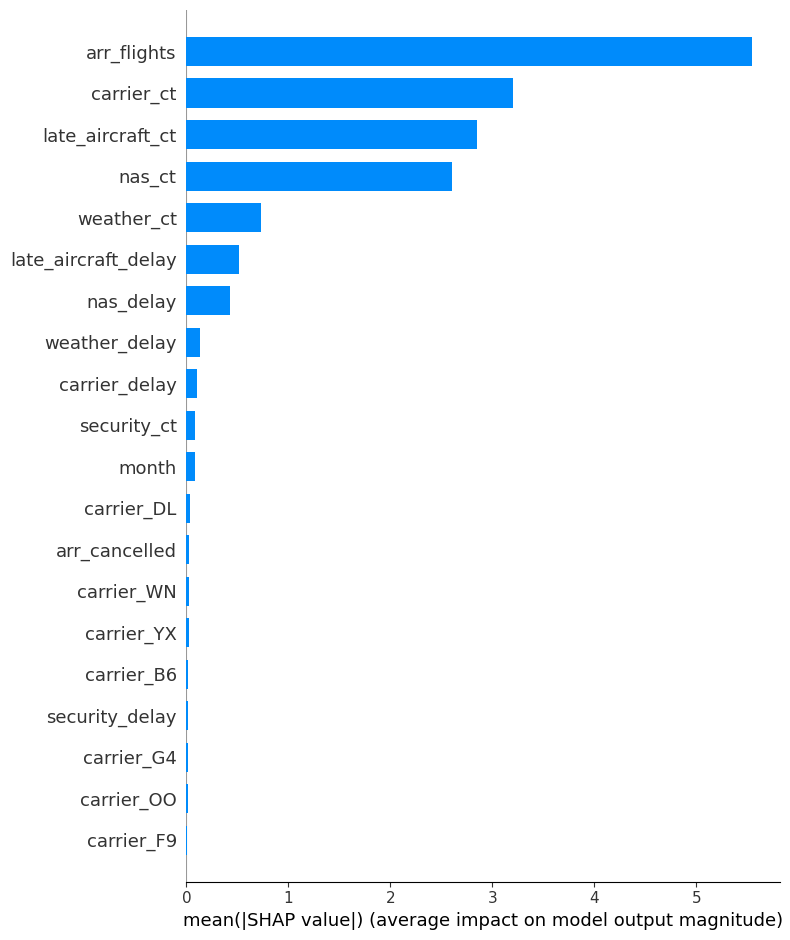

In [15]:
#SHAP EXPLAINABILITY (Classifier)
explainer_cls = shap.TreeExplainer(clf)
shap_values_cls = explainer_cls.shap_values(X_test)
shap.summary_plot(shap_values_cls, X_test, plot_type="bar")

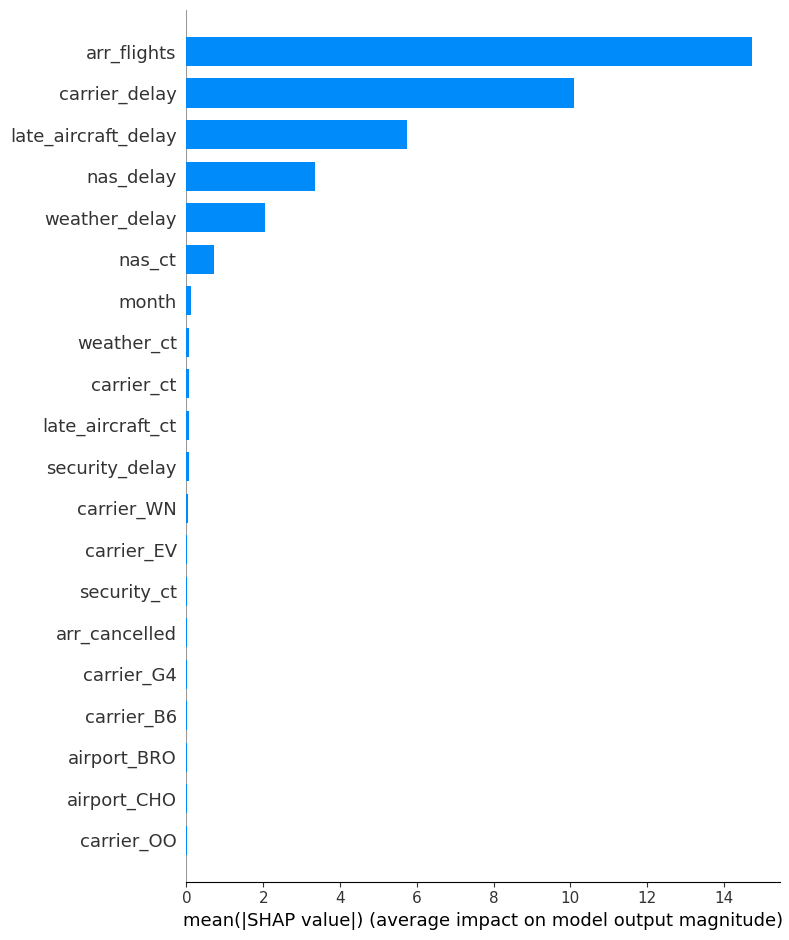

In [16]:
# SHAP EXPLAINABILITY (Regressor)
explainer_reg = shap.TreeExplainer(reg)
shap_values_reg = explainer_reg.shap_values(X_test)
shap.summary_plot(shap_values_reg, X_test, plot_type="bar")

In [ ]:
# Recommendations for Delay Mitigation
1.Focus on controllable delays:
Prioritize reducing carrier delay and late aircraft delay as these are the largest controllable contributors to delay (as shown in SHAP + EDA).
2. Targeted operational improvements:
Top carriers with high delays → implement stricter on-time departure checks.
Top airports → review ground operations and gate management.
3.Seasonal adjustments:
Delay fraction is higher in specific months (from EDA boxplot) → adjust flight schedules proactively during those periods
4.Proactive communication:
Notify passengers early about risk of delay (especially for high-risk carrier-airport-month combinations)
5.OAI-driven interventions:
Use SHAP OAI insights to focus on groups where carrier or late aircraft issues dominate — operational changes here will have the greatest effect.